# Computer Lab 5: Modeling Non-Stationary Time Series Data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import statsmodels.api as sm
import seaborn as sns

from astsadata import *

c:\Users\zshah\anaconda3\Lib\site-packages\astsadata\astsadata.py:15: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  birth = pd.read_csv(f"{path}/data/birth.csv", index_col=0, parse_dates=True)
c:\Users\zshah\anaconda3\Lib\site-packages\astsadata\astsadata.py:27: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  cardox = pd.read_csv(f"{path}/data/cardox.csv", index_col=0, parse_dates=True)
c:\Users\zshah\anaconda3\Lib\site-packages\astsadata\astsadata.py:30: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  chicken = pd.read_csv(f"{path}/data/chicken.csv", index_col=0, parse_dates=T

In [2]:
def acf1(x, nlags=None, acf_type='correlation', pacf=False, ax=None, return_values=False, **kwargs):
    """
    Calculate and optionally plot the autocorrelation or partial autocorrelation function.

    Parameters:
    - x: Input time series.
    - nlags: Number of lags to compute.
    - acf_type: 'correlation' for autocorrelation, 'covariance' for autocovariance.
    - pacf: If True, computes partial autocorrelation instead of autocorrelation.
    - ax: Matplotlib axis to plot on. If None, a new axis is created.
    - return_values: If True, the function will return the ACF/PACF values and lags.
    - **kwargs: Additional keyword arguments for the plot.

    Returns:
    - If return_values is True, returns (lags, values).
    """
    lags = np.arange(1, nlags + 1)

    if pacf:
        if acf_type == 'correlation':
            values = sm.tsa.pacf(x, nlags=nlags)[1:]
            ylabel = 'PACF'
    else:
        if acf_type == 'correlation':
            values = sm.tsa.acf(x, nlags=nlags, fft=False)[1:]
            ylabel = 'ACF'
        elif acf_type == 'covariance':
            values = sm.tsa.acovf(x, nlag=nlags)[1:]
            ylabel = 'ACoV'

    if return_values:
        return lags, values

    if ax is None:
        ax = plt.gca()

    ax.bar(lags, values, **kwargs)
    ax.axhline(0, color='black', linewidth=1)
    if acf_type == 'correlation':
        conf_level = 1.96 / np.sqrt(x.shape[0])
        ax.axhline(conf_level, color='red', linestyle='--', linewidth=1)
        ax.axhline(-conf_level, color='red', linestyle='--', linewidth=1)
    ax.set_xlabel('LAG')
    ax.set_ylabel(ylabel)

    return ax


## I. Integrated Autoregressive Moving Average (ARIMA) Models

### 1. Case Study: Quarterly U.S. GNP from 1947 to 2001

In [3]:
# Time series plot of X_t
data = pd.read_csv('dataset_group7.csv', index_col = 0, parse_dates = True)

# Convert 't' (integer time steps) into a real datetime index
start_date = "2024-07-01"
data.index = pd.date_range(start=start_date, periods=len(data), freq="D")

data.index = pd.to_datetime(data.index, format="%Y-%m-%d")  # Adjust format as needed

print(len(data))
# data.index = pd.to_datetime(data.index, format="%Y-%m-%d")  # Adjust format as needed

data.head()

100


C:\Users\zshah\AppData\Local\Temp\ipykernel_29088\1129321579.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data = pd.read_csv('dataset_group7.csv', index_col = 0, parse_dates = True)


,ProductP3
2024-07-01,266
2024-07-02,264
2024-07-03,317
2024-07-04,390
2024-07-05,440


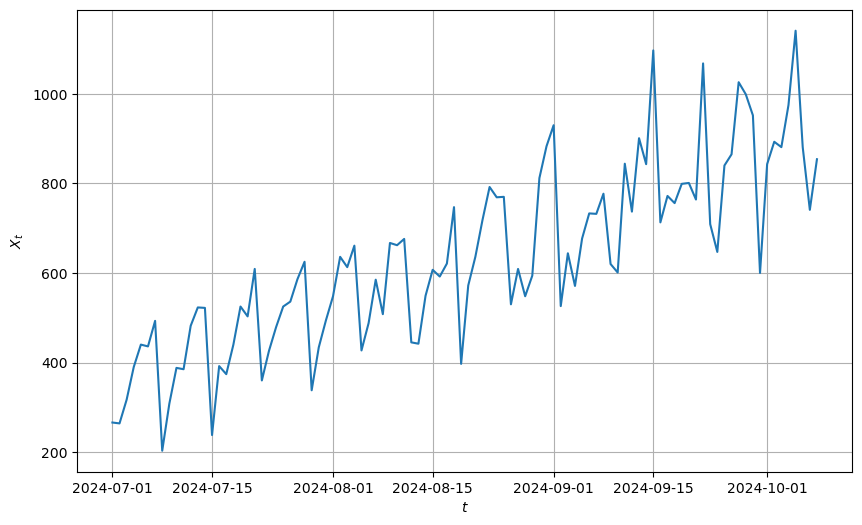

In [4]:
x_ts = data.copy()
plt.figure(figsize=(10, 6)) 
plt.plot(x_ts) 
plt.xlabel('$t$') 
plt.ylabel('$X_t$') 
plt.grid(True) 
plt.show()  


In [5]:
# Test the stationarity of X_t

from arch.unitroot import KPSS

# Perform KPSS test
kpss_test = KPSS(x_ts)
p_value = kpss_test.pvalue

# Print the results
print(f'p-value: {p_value:.3f}\n')

# Interpret the results
alpha = 0.05
if p_value >= alpha:
     print(f'The time series is stationary (fail to reject "H0: The time series is stationary" at a {100*alpha:.0f}% significance level).')
else: 
    print(f'The time series is not stationary (reject "H0: The time series is stationary" at a {100*alpha:.0f}% significance level).')


p-value: 0.000

The time series is not stationary (reject "H0: The time series is stationary" at a 5% significance level).


It is not stationary, we use difference method to make it stationary.

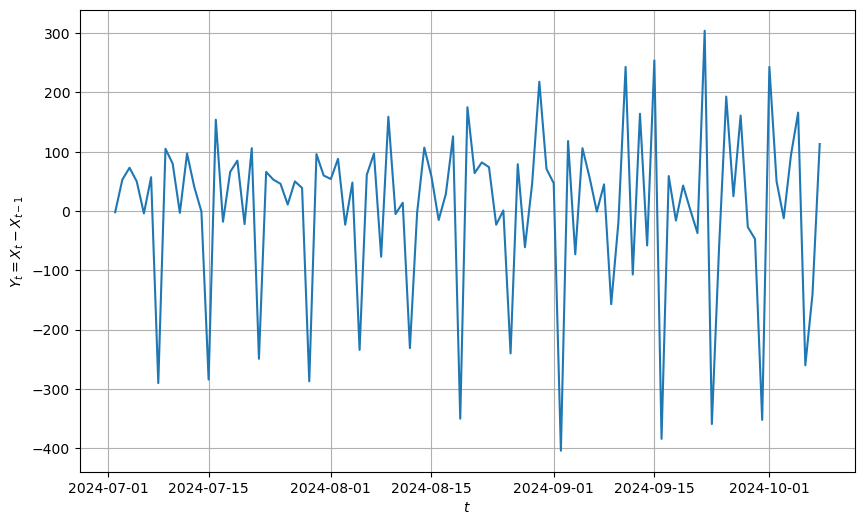

In [6]:
# Time series plot of Y_t := X_t - X_{t-1}

y_ts = data.diff().dropna() 


plt.figure(figsize=(10, 6)) 
plt.plot(y_ts) 
plt.xlabel('$t$') 
plt.ylabel('$Y_t = X_t - X_{t-1}$') 
plt.grid(True) 
plt.show()  


In [7]:
# Test the stationarity of Y_t

# Perform KPSS test
kpss_test = KPSS(y_ts)
p_value = kpss_test.pvalue

# Print the results
print(f'p-value: {p_value:.3f}\n')

# Interpret the results
alpha = 0.05
if p_value >= alpha:
     print(f'The time series is stationary (fail to reject "H0: The time series is stationary" at a {100*alpha:.0f}% significance level).')
else: 
    print(f'The time series is not stationary (reject "H0: The time series is stationary" at a {100*alpha:.0f}% significance level).')


p-value: 0.830

The time series is stationary (fail to reject "H0: The time series is stationary" at a 5% significance level).


The kpss test is telling us the data is now stationary, by d=1. But looking carefully on the above plots reveal that variance is getting bigger by the time, sa maybe logarithm of data is better choice to work with it.

------

In [8]:
# Construct the training set and test set

# Training set
train_data = np.log(data[:-14])

# Test set
test_data = np.log(data[-14:])


In [9]:
# Test the stationarity of z_t
z_ts = train_data.diff().dropna() 
# Perform KPSS test
kpss_test = KPSS(z_ts)
p_value = kpss_test.pvalue

# Print the results
print(f'p-value: {p_value:.3f}\n')

# Interpret the results
alpha = 0.05
if p_value >= alpha:
     print(f'The time series is stationary (fail to reject "H0: The time series is stationary" at a {100*alpha:.0f}% significance level).')
else: 
    print(f'The time series is not stationary (reject "H0: The time series is stationary" at a {100*alpha:.0f}% significance level).')


p-value: 0.402

The time series is stationary (fail to reject "H0: The time series is stationary" at a 5% significance level).


----------
Well done! now we decided to move on with u1_ts = np.log(data)

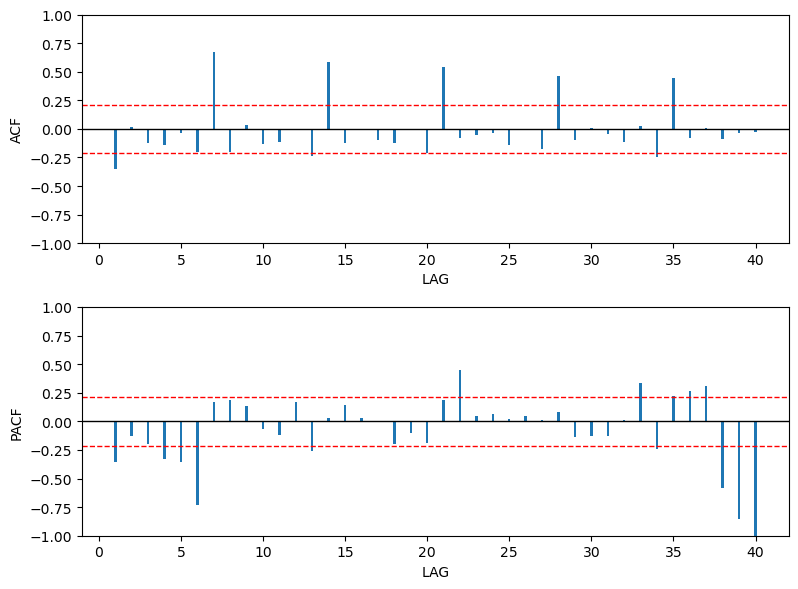

In [10]:
# Plot ACF amd PACF for U1_t - U1_{t-1}

fig, axes = plt.subplots(nrows = 2, figsize = (8,6))

acf1(train_data.diff().dropna(), nlags = 40, ax = axes[0], width = 0.15)
axes[0].set_ylim(-1, 1)

acf1(train_data.diff().dropna(), nlags = 40, ax = axes[1], width = 0.15, pacf = True)
axes[1].set_ylim(-1, 1)

fig.tight_layout()
plt.show()


---------------


It sweems it has seasonality, look ar lags 7, 14, 21 and 28 in ACF.

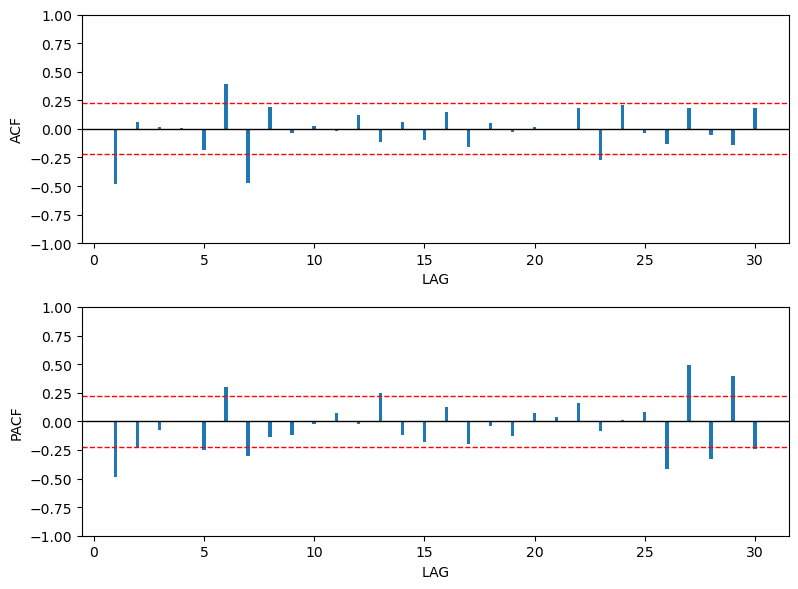

In [11]:
# Plot ACF amd PACF for (1-B^{12})(1-B)U1_t

fig, axes = plt.subplots(nrows = 2, figsize = (8,6))

acf1(train_data.diff().dropna().diff(7).dropna(), nlags = 30, ax = axes[0], width = 0.15)
axes[0].set_ylim(-1, 1)

acf1(train_data.diff().dropna().diff(7).dropna(), nlags = 30, ax = axes[1], width = 0.15, pacf = True)
axes[1].set_ylim(-1, 1)

fig.tight_layout()
plt.show()


- Initial Suggested Models

1. SARIMA(1,1,1)(1,1,1)_{7}
2. SARIMA(1,1,1)(0,1,1)_{7}
3. SARIMA(4,1,1)(1,1,1)_{7}
4. SARIMA(5,1,1)(1,1,1)_{7}


In [12]:
# Fit a SARIMA(1,1,1)(1,1,1)_{12} model to U1_t

model1 = sm.tsa.arima.ARIMA(train_data, order=(1, 1, 1), seasonal_order=(1, 1, 1, 7)).fit()
print(model1.summary())


                                    SARIMAX Results                                    
Dep. Variable:                       ProductP3   No. Observations:                   86
Model:             ARIMA(1, 1, 1)x(1, 1, 1, 7)   Log Likelihood                  56.681
Date:                         Thu, 30 Jan 2025   AIC                           -103.362
Time:                                 14:04:42   BIC                            -91.579
Sample:                             07-01-2024   HQIC                           -98.645
                                  - 09-24-2024                                         
Covariance Type:                           opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1282      0.158      0.810      0.418      -0.182       0.439
ma.L1         -0.9156      0.071    -12.911      0.000     

In [13]:
model2 = sm.tsa.arima.ARIMA(train_data, order=(1, 1, 1), seasonal_order=(0, 1, 1, 7)).fit()
print(model2.summary())

                                    SARIMAX Results                                    
Dep. Variable:                       ProductP3   No. Observations:                   86
Model:             ARIMA(1, 1, 1)x(0, 1, 1, 7)   Log Likelihood                  56.084
Date:                         Thu, 30 Jan 2025   AIC                           -104.168
Time:                                 14:04:43   BIC                            -94.741
Sample:                             07-01-2024   HQIC                          -100.395
                                  - 09-24-2024                                         
Covariance Type:                           opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1412      0.158      0.894      0.371      -0.168       0.451
ma.L1         -0.9222      0.072    -12.742      0.000     

In [14]:
model3 = sm.tsa.arima.ARIMA(train_data, order=(0, 1, 1), seasonal_order=(0, 1, 1, 7)).fit()
print(model3.summary())

                                    SARIMAX Results                                    
Dep. Variable:                       ProductP3   No. Observations:                   86
Model:             ARIMA(0, 1, 1)x(0, 1, 1, 7)   Log Likelihood                  55.497
Date:                         Thu, 30 Jan 2025   AIC                           -104.994
Time:                                 14:04:43   BIC                            -97.924
Sample:                             07-01-2024   HQIC                          -102.163
                                  - 09-24-2024                                         
Covariance Type:                           opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.8842      0.064    -13.792      0.000      -1.010      -0.759
ma.S.L7       -0.7149      0.114     -6.253      0.000     

In [15]:
# Forecast and confidence boundaries

k = 14 # Number of steps to forecast
u1_ts_preds = model3.get_forecast(steps = k)

# Extract the confidence intervals
conf_int = u1_ts_preds.conf_int()

# Create a DataFrame
forecast_df = pd.DataFrame({
    'predicted_mean': u1_ts_preds.predicted_mean,
    'lower_ci': conf_int.iloc[:, 0],
    'upper_ci': conf_int.iloc[:, 1]
})


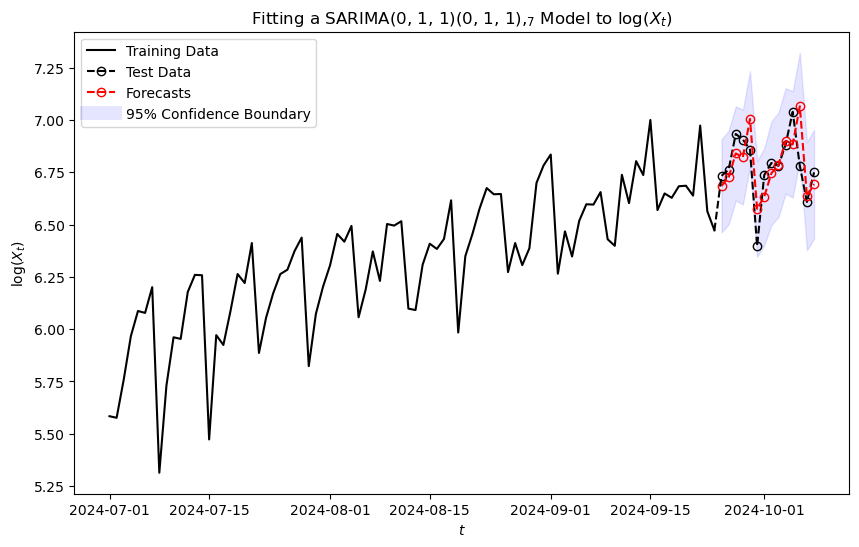

In [16]:
# Plots

from matplotlib.lines import Line2D

plt.figure(figsize = (10, 6))

# Training data plot
plt.plot(train_data.index, train_data, color='black', linestyle='-')

# Test data plot
plt.plot(test_data.index, test_data, color='black', linestyle='--', marker='o', markerfacecolor='none')

# Forecasts plot
plt.plot(forecast_df.index, forecast_df['predicted_mean'], color='red', linestyle='--', marker='o', markerfacecolor='none')

# Confidence boundary plot with lighter shading
plt.fill_between(forecast_df.index, forecast_df['lower_ci'], forecast_df['upper_ci'], color='blue', alpha=0.1)

# Connect the last point of u1_ts to the first point of test_data with a black dashed line
plt.plot([train_data.index[-1], test_data.index[0]], [train_data.iloc[-1], test_data.iloc[0]], 'k--')

# Custom legend elements
legend_elements = [
    Line2D([0], [0], color='black', linestyle='-', markeredgecolor='black', label='Training Data'),
    Line2D([0], [0], color='black', linestyle='--', marker='o', markerfacecolor='none', markeredgecolor='black', label='Test Data'),
    Line2D([0], [0], color='red', linestyle='--', marker='o', markerfacecolor='none', markeredgecolor='red', label='Forecasts'),
    Line2D([0], [0], color='blue', alpha=0.1, lw=10, label='95% Confidence Boundary')
]

plt.title('Fitting a SARIMA(0, 1, 1)(0, 1, 1),$_{7}$ Model to $\log(X_t)$')
plt.xlabel('$t$')
plt.ylabel('$\log(X_t)$')
plt.legend(handles=legend_elements, loc='upper left')
plt.show()


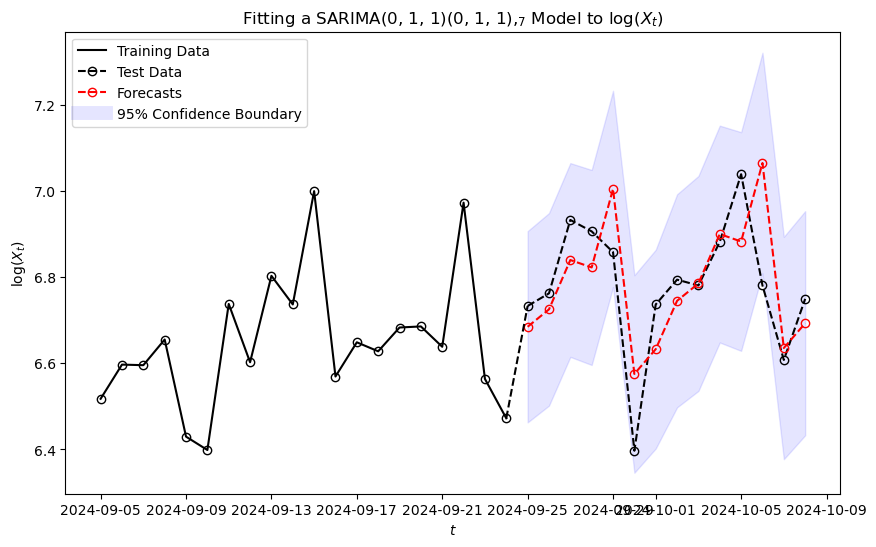

In [17]:
# Plots

plt.figure(figsize = (10, 6))

# Training data plot
plt.plot(train_data.index[-20:], train_data[-20:], color='black', linestyle='-', marker='o', markerfacecolor='none')

# Test data plot
plt.plot(test_data.index, test_data, color='black', linestyle='--', marker='o', markerfacecolor='none')

# Forecasts plot
plt.plot(forecast_df.index, forecast_df['predicted_mean'], color='red', linestyle='--', marker='o', markerfacecolor='none')

# Confidence boundary plot with lighter shading
plt.fill_between(forecast_df.index, forecast_df['lower_ci'], forecast_df['upper_ci'], color='blue', alpha=0.1)

# Connect the last point of train_data to the first point of u2_ts with a black dashed line
plt.plot([train_data.index[-1], test_data.index[0]], [train_data.iloc[-1], test_data.iloc[0]], 'k--')

# Custom legend elements
legend_elements = [
    Line2D([0], [0], color='black', linestyle='-', markeredgecolor='black', label='Training Data'),
    Line2D([0], [0], color='black', linestyle='--', marker='o', markerfacecolor='none', markeredgecolor='black', label='Test Data'),
    Line2D([0], [0], color='red', linestyle='--', marker='o', markerfacecolor='none', markeredgecolor='red', label='Forecasts'),
    Line2D([0], [0], color='blue', alpha=0.1, lw=10, label='95% Confidence Boundary')
]

plt.title('Fitting a SARIMA(0, 1, 1)(0, 1, 1),$_{7}$ Model to $\log(X_t)$')
plt.xlabel('$t$')
plt.ylabel('$\log(X_t)$')
plt.legend(handles=legend_elements, loc='upper left')
plt.show()


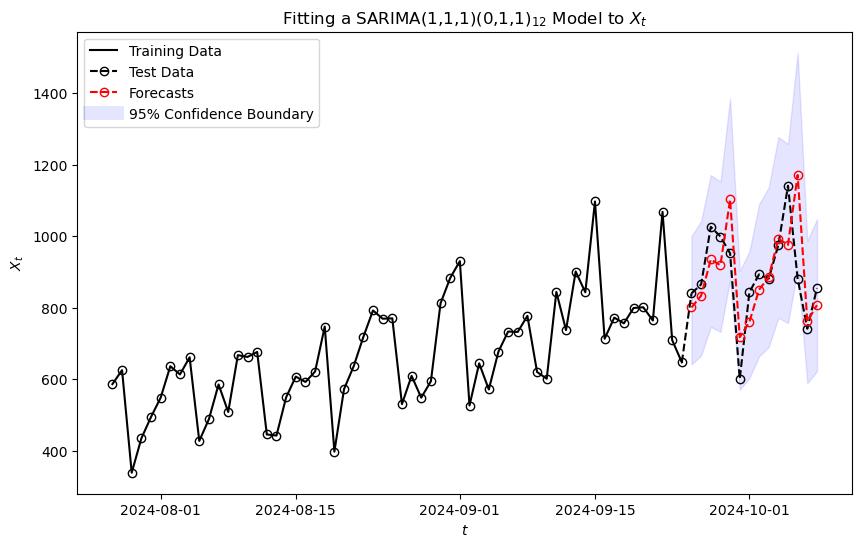

In [18]:
# Plots

plt.figure(figsize = (10, 6))

# Training data plot
plt.plot(train_data.index[-60:], train_data.apply(np.exp)[-60:], color='black', linestyle='-', marker='o', markerfacecolor='none')

# Test data plot
plt.plot(test_data.index, test_data.apply(np.exp), color='black', linestyle='--', marker='o', markerfacecolor='none')

# Forecasts plot
plt.plot(forecast_df.index, forecast_df.apply(np.exp)['predicted_mean'], color='red', linestyle='--', marker='o', markerfacecolor='none')

# Confidence boundary plot with lighter shading
plt.fill_between(forecast_df.index, forecast_df.apply(np.exp)['lower_ci'], forecast_df.apply(np.exp)['upper_ci'], color='blue', alpha=0.1)

# Connect the last point of u1_ts to the first point of test_data with a black dashed line
plt.plot([train_data.index[-1], test_data.index[0]], [train_data.apply(np.exp).iloc[-1], test_data.apply(np.exp).iloc[0]], 'k--')

# Custom legend elements
legend_elements = [
    Line2D([0], [0], color='black', linestyle='-', markeredgecolor='black', label='Training Data'),
    Line2D([0], [0], color='black', linestyle='--', marker='o', markerfacecolor='none', markeredgecolor='black', label='Test Data'),
    Line2D([0], [0], color='red', linestyle='--', marker='o', markerfacecolor='none', markeredgecolor='red', label='Forecasts'),
    Line2D([0], [0], color='blue', alpha=0.1, lw=10, label='95% Confidence Boundary')
]

plt.title('Fitting a SARIMA(1,1,1)(0,1,1)$_{12}$ Model to $X_t$')
plt.xlabel('$t$')
plt.ylabel('$X_t$')
plt.legend(handles=legend_elements, loc='upper left')
plt.show()


In [19]:
# Calculate the Mean Absolute Percentage Error (MAPE)

errors = np.abs((test_data.apply(np.exp)['ProductP3'] - forecast_df.apply(np.exp)['predicted_mean']) / test_data.apply(np.exp)['ProductP3'])
mape = np.mean(errors) * 100

print(f'The Mean Absolute Percentage Error (MAPE) is: {mape:.2f}%')



The Mean Absolute Percentage Error (MAPE) is: 9.53%


## III. Hybrid SARIMA-Regression Models

### 3. Case Study: Weekly Peak Australian Electricity Demand from 2012 to 2016

In [26]:
path = "C:\zshahpouri\Forecasting_Predictive_Analytics\products_demand_data_series.csv"

X = pd.read_csv(path,  index_col = 0, parse_dates = True)
# Convert 't' (integer time steps) into a real datetime index
start_date = "2024-07-01"
data.index = pd.date_range(start=start_date, periods=len(data), freq="D")

x_ts = pd.Series(X.values[:,0], index = X.index, name='ProductP3')
x1_ts = x_ts[:-14]
x2_ts = x_ts[-14:]


C:\Users\zshah\AppData\Local\Temp\ipykernel_29088\3532562709.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  X = pd.read_csv(path,  index_col = 0, parse_dates = True)


In [29]:
# Define exogenous time series data

maxt_ts = pd.Series(X.values[:,6], index = X.index, name='temperature')
maxt1_ts = maxt_ts[:-14]
maxt2_ts = maxt_ts[-14:]

mint_ts = pd.Series(X.values[:,5], index = X.index, name='price')
mint1_ts = mint_ts[:-14]
mint2_ts = mint_ts[-14:]


c:\Users\zshah\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\zshah\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\zshah\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\zshah\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_cat

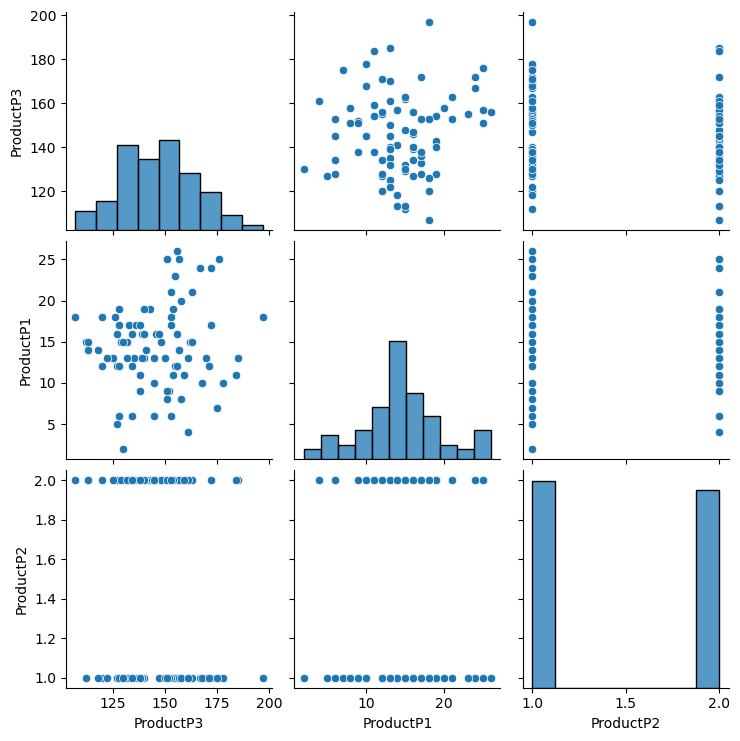

In [30]:
# Create pairplot

df = pd.concat([x1_ts, maxt1_ts, mint1_ts], axis=1)

# Create pairplot
sns.pairplot(df)

# Show the plot using matplotlib's plt.show()
plt.show()


In [54]:
# Define exogenous time series data

maxt_2_ts = pow(maxt_ts, 2)
maxt1_2_ts = maxt_2_ts[:-52]
maxt2_2_ts = maxt_2_ts[-52:]

mint_2_ts = pow(mint_ts, 2)
mint1_2_ts = mint_2_ts[:-52]
mint2_2_ts = mint_2_ts[-52:]

exog1_ts = pd.concat([maxt1_ts, maxt1_2_ts, mint1_ts, mint1_2_ts], axis=1)
exog2_ts = pd.concat([maxt2_ts, maxt2_2_ts, mint2_ts, mint2_2_ts], axis=1)


In [ ]:
# Fit a hybrid SARIMA(1,0,1)(0,1,1)_{52}-regression model to X1_t

model3 = sm.tsa.arima.ARIMA(x1_ts, exog=exog1_ts, order=(1, 0, 1), seasonal_order=(0, 1, 1, 52)).fit()

print(model3.summary())


In [ ]:
# Fit a hybrid SARIMA(1,0,0)(0,1,1)_{52}-regression model to X1_t

model4 = sm.tsa.arima.ARIMA(x1_ts, exog=exog1_ts, order=(1, 0, 0), seasonal_order=(0, 1, 1, 52)).fit()

print(model4.summary())


In [ ]:
# Fit a hybrid SARIMA(0,0,0)(0,1,1)_{52}-regression model to X1_t

model5 = sm.tsa.arima.ARIMA(x1_ts, exog=exog1_ts, order=(0, 0, 0), seasonal_order=(0, 1, 1, 52)).fit()

print(model5.summary())


In [58]:
# Forecasts and confidence boundaries

k = 52 # Number of steps to forecast
x1_ts_preds = model5.get_forecast(steps = k, exog=exog2_ts)

# Extract the confidence intervals
conf_int = x1_ts_preds.conf_int()

# Create a DataFrame
forecast_df = pd.DataFrame({
    'predicted_mean': x1_ts_preds.predicted_mean,
    'lower_ci': conf_int.iloc[:, 0],
    'upper_ci': conf_int.iloc[:, 1]
})


In [ ]:
# Plots

from matplotlib.lines import Line2D

plt.figure(figsize = (10, 6))

# Test data plot
plt.plot(x2_ts.index, x2_ts, color='black', linestyle='-', marker='o', markerfacecolor='none')
plt.ylim(min(x2_ts)*0.86, max(x2_ts) * 1.14)

# Forecasts plot
plt.plot(forecast_df.index, forecast_df['predicted_mean'], color='green', linestyle='-', marker='o', markerfacecolor='none')

# Forecasts plot
plt.plot(forecast_df_model2.index, forecast_df_model2['predicted_mean'], color='red', linestyle='--', marker='o', markerfacecolor='none')

# Confidence boundary plot with lighter shading
plt.fill_between(forecast_df.index, forecast_df['lower_ci'], forecast_df['upper_ci'], color='blue', alpha=0.1)

# Custom legend elements
legend_elements = [
    Line2D([0], [0], color='black', linestyle='-', marker='o', markerfacecolor='none', markeredgecolor='black', label='Test Data'),
    Line2D([0], [0], color='red', linestyle='--', marker='o', markerfacecolor='none', markeredgecolor='red', label='Forecasts with the SARIMA Model'),
    Line2D([0], [0], color='green', linestyle='-', marker='o', markerfacecolor='none', markeredgecolor='green', label='Forecasts with the Hybrid SARIMA-Regression Model'),
    Line2D([0], [0], color='blue', alpha=0.1, lw=10, label='95% Confidence Boundary')
]

plt.title('Fitting a hybrid SARIMA(0,0,0)(0,1,1)$_{12}-$Regression Model to $X_t$')
plt.xlabel('$t$')
plt.ylabel('$X_t$')
plt.legend(handles=legend_elements, loc='upper left')

plt.tight_layout()
plt.show()


In [ ]:
# Calculate the Mean Absolute Percentage Error (MAPE)

errors = np.abs((x2_ts - forecast_df['predicted_mean']) / x2_ts)
mape = np.mean(errors) * 100

print(f'The Mean Absolute Percentage Error (MAPE) is: {mape:.2f}%')


In [ ]:
# Calculating percentage improvement

per_improvement = (mape_model2 - mape)/mape_model2 * 100
print(f'The percentage improvement in MAPE from the SARIMA Model 2 to the hybrid SARIMA-regression Model 5 is: {per_improvement:.2f}%')


## IV. Assignment Question

- Find a primary monthly time series dataset with seasonality and trends on Google Trends.  

<ol style="list-style-type: lower-roman;">
<li>Use the dataset, excluding the last 12 months, as the training set, and designate the last 12 months as the test set.</li> 
<li>Fit an appropriate SARIMA model.</li>  
<li>Predict the values for the last 12 months, plot the forecasts against the test set values, and calculate the MAPE (Mean Absolute Percentage Error).</li>  
<li>Select at least two additional secondary time series from Google Trends. Use these as explanatory variables to fit a hybrid SARIMA-Regression model to your primary time series training set.</li>
<li>Predict the values for the last 12 months, plot the forecasts against the test set values for both the SARIMA model and the hybrid SARIMA-Regression model, and compare the MAPE of both models.</li>  
</ol>
